In [1]:
!pip install transformers
!pip install datasets

### Model

In [2]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer,BertModel,TrainingArguments,Trainer
from transformers import PretrainedConfig
from datasets import Dataset
import torch
import torch.nn as nn
from torch.utils.data import RandomSampler, DataLoader,SequentialSampler
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import notebook
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [3]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
#change pretrained models?
tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-esg',model_max_length=256)
esg_bert = BertModel.from_pretrained('yiyanghkust/finbert-esg',output_attentions=True) 

Some weights of the model checkpoint at yiyanghkust/finbert-esg were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
%cd drive/MyDrive/'NLP Final Project'

[Errno 2] No such file or directory: 'drive/MyDrive/NLP Final Project'
/content/drive/MyDrive/NLP Final Project


In [5]:
#way 1
final_dataset = pd.read_csv("final_dataset.csv")

In [6]:
final_dataset

,symbol,year,truncated_text,score
0,a,2016,if it meets it will likely react the way the a...,0.884762
1,a,2019,markets closed in observance of the thanksgivi...,0.883315
2,a,2020,markets closed in observance of president's da...,0.875676
3,a,2021,this sweetens the deal for those who hold and ...,0.886514
4,aal,2016,#good morning traders of the r/wallstreetbets ...,0.705000
...,...,...,...,...
1499,zbra,2021,**what's on everyone's radar for today's tradi...,0.395114
1500,zts,2016,$pzza- buy a 75/80 nov16 call spread or sell n...,0.452652
1501,zts,2019,reviewing overnight developments:* equity indi...,0.587835
1502,zts,2020,i posted this in the daily discussion thread b...,0.653376


In [7]:
from sklearn.model_selection import train_test_split
train_text,val_text,train_score,val_score = train_test_split(list(final_dataset["truncated_text"]),list(final_dataset["score"]),test_size=0.2)

In [8]:
def getGrade(score):
    if score <= 0.25:
        return 0
    elif score <= 0.50:
        return 1
    elif score <= 0.75:
        return 2
    elif score <= 1:
        return 3

In [9]:
train_grade = [getGrade(score) for score in train_score]
val_grade = [getGrade(score) for score in val_score]

In [10]:
train_dataset = pd.DataFrame({"train_text":train_text,"train_grade":train_grade})
val_dataset = pd.DataFrame({"val_text":val_text,"val_grade":val_grade})

In [11]:
train_encoding = tokenizer(train_text,truncation=True,padding=True)
val_encoding = tokenizer(val_text,truncation=True,padding=True)

In [12]:
class RedditDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

In [13]:
train_dataset = RedditDataset(train_encoding,train_grade)
val_dataset = RedditDataset(val_encoding,val_grade)

In [14]:
class ClassificationModel(nn.Module):
    def __init__(self, bert,num_classes):
        super().__init__()
        self.bert = bert
        self.W = nn.Linear(bert.config.hidden_size, num_classes)
        self.num_classes = num_classes
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        h, _, attn = self.bert(input_ids=input_ids, 
                               attention_mask=attention_mask,
                               token_type_ids=token_type_ids).values()
        h_cls = h[:,0,:]
        output = self.W(h_cls)
        return output, attn

In [15]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False
        
def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [16]:
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler,batch_size=4)
val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=4)

In [17]:
device = 'cuda' if torch.cuda.device_count() > 0 else 'cpu'

In [18]:
model = ClassificationModel(esg_bert,4)
freeze_model(model.bert)

In [19]:
def train_and_val(model,num_epochs):
    optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=2e-04, eps=1e-08)
    criterion = nn.CrossEntropyLoss().to(device)
    scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=0, verbose=True)

    model.to(device)

    # Train!
    train_losses = []
    val_losses =[]
    model.zero_grad()
    for i in notebook.tqdm(range(num_epochs), desc="Epoch"):
        epoch_iterator = notebook.tqdm(train_dataloader, desc="Training")
        train_losses_batch = []
        for step, batch in enumerate(epoch_iterator):
            model.train()
            batch = tuple(batch[t].to(device) for t in batch)
            logits, _ = model(*batch[:-1])

            labels = batch[-1]
            train_loss = criterion(logits.view(-1,model.num_classes), labels.view(-1))
            
            train_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            train_losses_batch.append(train_loss.item())
            optimizer.step()
            model.zero_grad()
        train_losses.append(np.mean(train_losses_batch))
        # print("Epoch {}: training loss {} ".format(i+1,np.mean(train_losses_batch)))
        # Eval!
        val_losses_batch = []
        for batch in notebook.tqdm(val_dataloader, desc="Evaluating"):
            model.eval()
            batch = tuple(batch[t].to(device) for t in batch)

            with torch.no_grad():
                logits, attn = model(*batch[:-1])
                
                labels = batch[-1]
                val_loss = criterion(logits.view(-1,model.num_classes), labels.view(-1))
                val_losses_batch.append(val_loss.item())
        val_losses.append(np.mean(val_losses_batch))
        scheduler.step(np.mean(val_losses_batch))
        print("Epoch {}: val loss {} ".format(i+1,np.mean(val_losses_batch)))
    return train_losses,val_losses


In [20]:
train_losses,val_losses = train_and_val(model, 10) #epoch can change?

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/301 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 1: val loss 1.0792983872325796 


Training:   0%|          | 0/301 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 00002: reducing learning rate of group 0 to 2.0000e-05.
Epoch 2: val loss 1.0994955693420612 


Training:   0%|          | 0/301 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 00003: reducing learning rate of group 0 to 2.0000e-06.
Epoch 3: val loss 1.0802438878699352 


Training:   0%|          | 0/301 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 00004: reducing learning rate of group 0 to 2.0000e-07.
Epoch 4: val loss 1.0792497176873057 


Training:   0%|          | 0/301 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 00005: reducing learning rate of group 0 to 2.0000e-08.
Epoch 5: val loss 1.079211582478724 


Training:   0%|          | 0/301 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 00006: reducing learning rate of group 0 to 2.0000e-09.
Epoch 6: val loss 1.0792061866898286 


Training:   0%|          | 0/301 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 7: val loss 1.0792057678887719 


Training:   0%|          | 0/301 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 8: val loss 1.0792051694895093 


Training:   0%|          | 0/301 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 9: val loss 1.0792048126459122 


Training:   0%|          | 0/301 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 10: val loss 1.079204346788557 


In [21]:
pos_N = 0
N = 0
for batch in notebook.tqdm(val_dataloader, desc="Evaluating"):
    model.eval()
    batch = tuple(batch[t].to(device) for t in batch)
    with torch.no_grad():
        logits, attn = model(*batch[:-1])
        labels = batch[-1]
        labels = labels.reshape(-1, 1)
        true_prediction = logits.argmax(-1) == labels
        pos_N +=  true_prediction.sum().item()
        N += true_prediction.numel()
print(pos_N/N)

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

0.5387177352206495


In [22]:
torch.save(model,"esg_bert_reddit.pt")

In [53]:
def plot_over_training(per_epoch_metrics, title_name: str):
  """Utility function to plot train/val accuracies and losses.

  @param per_epoch_metrics: a dictionary of lists, where each list represents a metric over the
      course of training.
  @param title_name: String to show on the plot title.
  """
  t_train = np.arange(0, len(per_epoch_metrics['train_losses']))
  train_loss = per_epoch_metrics['train_losses']

  t_val = np.arange(0, len(per_epoch_metrics['val_losses']))
  val_loss = per_epoch_metrics['val_losses']

  fig, ax1 = plt.subplots()

  color = 'tab:red'
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('loss', color=color)
  ax1.plot(t_train, train_loss, color=color, linewidth=1, label = 'train_loss')
  ax1.plot(t_val, val_loss, color=color, linestyle='dashed', linewidth=1, label = 'val_loss')
  ax1.tick_params(axis='y', labelcolor=color)
  ax1.legend(loc='upper left')

  fig.tight_layout() 
  plt.title(title_name)
  plt.show()

In [54]:
per_epoch_metrics = {
    'train_losses': train_losses,
    'val_losses': val_losses,
}

title_name = 'Classification: freeze_model, lr=2e-04, eps=1e-08'

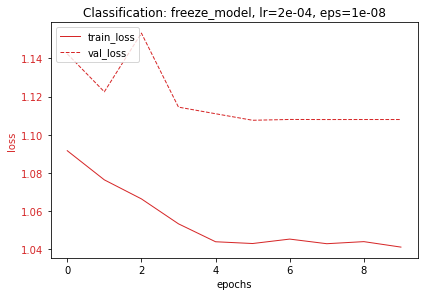

In [55]:
plot_over_training(per_epoch_metrics=per_epoch_metrics, title_name=title_name)

In [56]:
!pip install huggingface_hub

In [76]:
from huggingface_hub import notebook_login

In [79]:
notebook_login()

ValueError: Invalid token passed!

In [72]:
class ESGRedditConfig(PretrainedConfig):
    model_type = "resnet"

    def __init__(
        self,
        architectures = ["BertForSequenceClassification"],
        num_classes: int = 4,
        **kwargs
    ):  
        self.architectures = architectures
        self.num_classes = num_classes
        super().__init__(**kwargs)

In [74]:
id2label = {
    0: "D",
    1: "C",
    2: "B",
    3: "A"
}
label2id = {
    "D" : 0,
    "C" : 1,
    "B" : 2,
    "A" : 3
}
esgRedditConfig = ESGRedditConfig(num_classes=4,id2label=id2label,label2id=label2id)

In [88]:
esgRedditConfig.push_to_hub("admation/ESG-BERT-Reddit")

RepositoryNotFoundError: 401 Client Error. (Request ID: Root=1-638d9f9d-0e9e724b68f8c70900dc8ab5)

Repository Not Found for url: https://huggingface.co/api/repos/create.
Please make sure you specified the correct `repo_id` and `repo_type`.
If the repo is private, make sure you are authenticated.
Unauthorized - Unauthorized

In [60]:
model.push_to_hub("my-awesome-model")

AttributeError: 'ClassificationModel' object has no attribute 'push_to_hub'

In [87]:
torch.save(model, 'finbert-esg-reddit-classification.pt')

PicklingError: Can't pickle <class '__main__.ClassificationModel'>: it's not the same object as __main__.ClassificationModel

In [ ]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
# model_benchmark = AutoModelForSequenceClassification.from_pretrained('yiyanghkust/finbert-esg', 
#                                                            num_labels = 1,ignore_mismatched_sizes=True)